In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_hidden = 32

nx = 5
nu = 1
ny = 1
seq_len = 1000
dtype = "float32"

In [3]:
def nn_fun(x):
    out = x @ w1.transpose() + b1
    out = np.tanh(out)
    out = out @ w2.transpose() + b2
    return out

In [20]:
w1 = np.random.randn(n_hidden, nu) / np.sqrt(nu) * 5 / 3
b1 = np.random.randn(1, n_hidden) * 1.0
w2 = np.random.randn(ny, n_hidden) / np.sqrt(n_hidden)
b2 = np.random.randn(1, ny) * 1.0


G1 = control.drss(states=nx,
                  inputs=nu,
                  outputs=ny,
                  strictly_proper=True)

G2 = control.drss(states=nx,
                  inputs=nu,
                  outputs=ny,
                  strictly_proper=False)

u = np.random.randn(seq_len, nu).astype(dtype)  

# G1
x = control.forced_response(G1, T=None, U=u.transpose(), X0=0.0)
x = x.y.astype(dtype).transpose()  # T, C
x = (x - x.mean(axis=0)) / (x.std(axis=0))

# F
x = nn_fun(x)

# G2
x = control.forced_response(G2, T=None, U=x.transpose(), X0=0.0)
y = x.y.astype(dtype).transpose()
y = (y - y.mean(axis=0))/(y.std(axis=0)) # normalize?

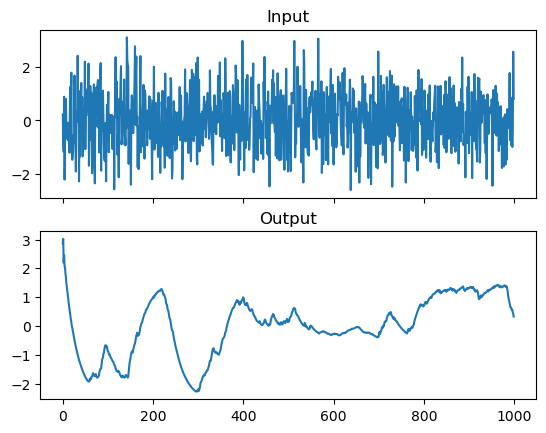

In [21]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].set_title("Input")
ax[0].plot(u[:, 0])
ax[1].set_title("Output")
ax[1].plot(y[:, 0]);

In [12]:
import torch
from torch.utils.data import DataLoader, IterableDataset

In [13]:
class LinearDynamicalDataset(IterableDataset):
    def __init__(self, nx=5, nu=1, ny=1, seq_len=500, strictly_proper=True, dtype="float32", normalize=True):
        super(LinearDynamicalDataset).__init__()
        self.nx = nx
        self.nu = nu
        self.ny = ny
        self.seq_len = seq_len
        self.strictly_proper = strictly_proper
        self.dtype = dtype
        self.normalize = normalize

    def __iter__(self):
        while True:  # infinite dataset
        #for _ in range(1000):
            sys = control.drss(states=self.nx,
                               inputs=self.nu,
                               outputs=self.ny,
                               strictly_proper=self.strictly_proper)
            u = np.random.randn(self.nu, self.seq_len).astype(self.dtype)  # C, T as python-control wants
            y = control.forced_response(sys, T=None, U=u, X0=0.0)
            u = u.transpose()  # T, C
            y = y.y.transpose().astype(self.dtype)  # T, C
            if self.normalize:
                y = (y - y.mean(axis=0))/(y.std(axis=0))

            yield torch.tensor(y), torch.tensor(u)

In [ ]:
train_ds = LinearDynamicalDataset(nx=5, nu=2, ny=3, seq_len=1000)
train_dl = DataLoader(train_ds, batch_size=32)

In [ ]:
batch_y, batch_u = next(iter(train_dl))

In [ ]:
batch_y.shape, batch_u.shape